# Imports

In [420]:
import os
import csv
import numpy as np
import pprint

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import pandas as pd

from timeit import default_timer as timer
import joblib

from tensorflow.keras import layers, models
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Libs options

In [41]:
#np.set_printoptions(threshold=16)
pp = pprint.PrettyPrinter(indent=4, width=90)

# Dataset

In [391]:
def list_first_val(arr):
    for i in arr:
        if i > 0:
            return 1
    return -1

def get_aabb2D(data):
    """aligned-axis bounding-box (bounding square)"""
    x1 = 0xffff
    y1 = 0xffff
    x2 = 0
    y2 = 0
    # y1
    for j in range(len(data)):
        if list_first_val(data[j]) > 0:
            y1 = j
            break
    # y2
    for j in range(len(data)):
        end = len(data)-j-1
        if list_first_val(data[end]) > 0:
            y2 = end
            break
    # x1, x2
    for j in range(len(data)):
        ydata = data[j]
        val = 0xffff
        last = 0
        for i in range(len(ydata)):
            if ydata[i] > 0:
                x1 = min(x1,i)
                x2 = max(x2,i)
    return (x1,y1, x2+1,y2+1)
    
def get_X_aabb2D(X):
    aabbs = []
    for i in range(len(X)):
        aabbs.append(get_aabb2D(X[i]))
        #if i > 10: break
    return aabbs

def read_aabb_csv(path):
    df = pd.read_csv(path)
    return list(df.itertuples(index=False, name=None))

def write_aabb_csv(X, path):
    aabb = get_X_aabb2D(X)
    df = pd.DataFrame(aabb, columns=['x1','y1','x2','y2'])
    df.to_csv(path, index=False)
    return aabb
    
    
def scaling(X_train, X_val, X_test):
    X_train_scaled = X_train / 255.
    X_val_scaled = X_val / 255.
    X_test_scaled = X_test / 255.
    return X_train_scaled, X_val_scaled, X_test_scaled

def get_data():
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
    #train_test_split(self.train_index , test_size = 0.25, random_state=1)
    
    # load aabb
    if os.path.isfile('aabb_train.csv'):
        aabb_train = read_aabb_csv('aabb_train.csv')
        aabb_test = read_aabb_csv('aabb_test.csv')
        print("bounding-squares csv loaded")
    else: # or compute them (slow!)
        aabb_train = write_aabb_csv(X_train, 'aabb_train.csv')
        aabb_test = write_aabb_csv(X_test, 'aabb_test.csv')
        print("bounging-squares csv computed")
    #display(df_train)
    
    # add a dim: (28, 28) -> (28, 28, 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    
    # to categorical
    y_train_cat = to_categorical(y_train, num_classes=10, dtype ="uint8")
    y_test_cat = to_categorical(y_test, num_classes=10, dtype ="uint8")
    
    # split train/validation
    X_train, X_val, y_train_cat, y_val_cat = train_test_split(X_train, y_train_cat, test_size=0.25, random_state=1)
    aabb_train, aabb_val = train_test_split(aabb_train, test_size=0.25, random_state=1)
    
    # scaling
    X_train_scaled, X_val_scaled, X_test_scaled = scaling(X_train,X_val,X_test)
    
    return (X_train_scaled, y_train_cat),(X_val_scaled, y_val_cat),(X_test_scaled, y_test_cat),(aabb_train, aabb_val, aabb_test)

            
(X_train_scaled, y_train_cat),(X_val_scaled, y_val_cat),(X_test_scaled, y_test_cat),(aabb_train, aabb_val, aabb_test) = get_data()

#print("train/valid:", X_train.shape, y_train.shape)
#print("test:", X_test.shape, y_test.shape)

print("train:", X_train_scaled.shape, y_train_cat.shape);
print("val:", X_val_scaled.shape, y_val_cat.shape);
print("test:", X_test_scaled.shape, y_test_cat.shape);

print("aabb_train:", aabb_train[0]);
print("aabb_val:", aabb_val[0]);
print("aabb_test:", aabb_test[0]);

bounding-squares csv loaded
train: (45000, 28, 28, 1) (45000, 10)
val: (15000, 28, 28, 1) (15000, 10)
test: (10000, 28, 28, 1) (10000, 10)
aabb_train: (7, 4, 21, 24)
aabb_val: (8, 5, 20, 25)
aabb_test: (6, 7, 22, 27)


In [359]:
list(X_train[0][14])

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.24705882]), array([0.96078431]), array([0.94509804]), array([0.14901961]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]

# Draw image + Bounding Box

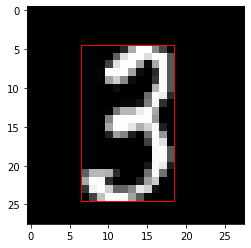

In [392]:
def plt_rectangle(tup):
    x1 = tup[0]
    y1 = tup[1]
    x2 = tup[2]
    y2 = tup[3]
    plt.gca().add_patch(Rectangle((x1-0.5,y1-0.5),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none'))
    return


idx = 144
plt.imshow(X_train_scaled[idx], cmap='gray');
plt_rectangle(aabb_train[idx])


label is: Number 5


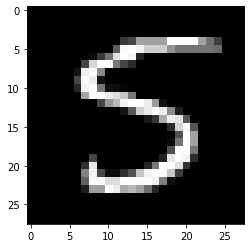

In [377]:
labels = ["Number 0",
          "Number 1",
          "Number 2",
          "Number 3",
          "Number 4",
          "Number 5",
          "Number 6",
          "Number 7",
          "Number 8",
          "Number 9"]

def categorical_to_id(arr_cat, labels=None):
    res = -1
    for i in range(len(arr_cat)):
        if arr_cat[i]:
            res = i
            break
    if labels is None:
        return res
    return labels[res]

item = 21

print("label is:", categorical_to_id(y_train_cat[item], labels))
plt.imshow(X_train_scaled[item], cmap='gray');

In [378]:
def get_model(X):
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (4,4), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

model = get_model(X_train_scaled)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 10)               

# Train 

In [379]:

def run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat,
        opti = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        epochs = 5,
        batch_size = 32):
    
    start_time = timer()
    
    model.compile(optimizer=opti, 
                  loss=loss,
                  metrics=metrics)
    
    es = EarlyStopping(patience = 10, restore_best_weights = True)
    history = model.fit(X_train_scaled, 
                        y_train_cat,
                        #validation_split = 0.3, # auto val generation
                        validation_data = (X_val_scaled, y_val_cat),
                        batch_size = batch_size,
                        epochs = epochs,
                        callbacks = [es],
                        verbose = 1)
    
    training_time = timer() - start_time
    print("training time:", training_time)
    
    return history

history = run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat)

Epoch 1/5
1407/1407 [==============================] - 27s 19ms/step - loss: 0.4682 - accuracy: 0.8442 - val_loss: 0.1844 - val_accuracy: 0.9467
Epoch 2/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.1269 - accuracy: 0.9627 - val_loss: 0.1315 - val_accuracy: 0.9611
Epoch 3/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0998 - accuracy: 0.9705 - val_loss: 0.1117 - val_accuracy: 0.9673
Epoch 4/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0828 - accuracy: 0.9752 - val_loss: 0.0907 - val_accuracy: 0.9745
Epoch 5/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0699 - accuracy: 0.9784 - val_loss: 0.0948 - val_accuracy: 0.9725
training time: 127.72920079994947


# Plot results

In [380]:
def plot_history(history, labels = ["loss"]):
    h = history.history
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
        x_axis = np.arange(len(h[labels[0]]))
        for i in range(len(labels)):
            l = labels[i]
            L = l.capitalize()
            ax[i].set_title(l)
            ax[i].plot(x_axis, h[l], color="blue", linestyle=":", marker="X", label="Train "+L)
            ax[i].plot(x_axis, h['val_'+l], color="orange", linestyle="-", marker="X", label="Val "+L)
            ax[i].grid(axis="x", linewidth=0.5)
            ax[i].grid(axis="y", linewidth=0.5)
            ax[i].legend()
        plt.show()

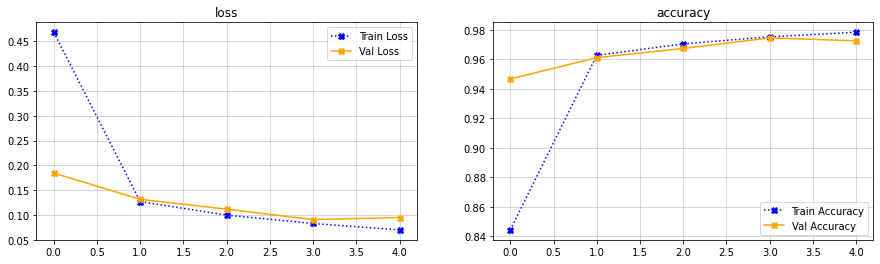

In [381]:
plot_history(history, ["loss", "accuracy"])

# Evaluation vs test set

In [397]:
def evaluate(X_train_scaled,y_train_cat, X_val_scaled,y_val_cat, X_test_scaled, y_test_cat):
    eval_res = {
        "train": model.evaluate(X_train_scaled, y_train_cat, batch_size=None, verbose = 1)[1],
        "val": model.evaluate(X_val_scaled, y_val_cat, batch_size=None, verbose = 1)[1],
        "test": model.evaluate(X_test_scaled, y_test_cat, batch_size=None, verbose = 1)[1]
    }
    return eval_res

eval_res = evaluate(X_train_scaled,y_train_cat, X_val_scaled,y_val_cat, X_test_scaled, y_test_cat)
print(f'The accuracy on the train set is of {eval_res["train"]*100:.2f} %')
print(f'The accuracy on the val set is of {eval_res["val"]*100:.2f} %')
print(f'The accuracy on the test set is of {eval_res["test"]*100:.2f} %')

313/313 [==============================] - 2s 8ms/step - loss: 0.0753 - accuracy: 0.9768
The accuracy on the train set is of 97.98 %
The accuracy on the val set is of 97.25 %
The accuracy on the test set is of 97.68 %


In [398]:
model.predict(X_test_scaled)

array([[6.5325336e-16, 6.6724130e-07, 6.5385684e-08, ..., 9.9994528e-01,
        3.0016611e-07, 6.9486015e-07],
       [1.6788428e-07, 7.1038638e-04, 9.9926776e-01, ..., 1.8594360e-08,
        1.4008916e-05, 3.4854362e-13],
       [5.8247611e-09, 9.9740124e-01, 2.0772277e-05, ..., 2.4532803e-04,
        1.5641943e-03, 1.1115384e-07],
       ...,
       [1.0115179e-18, 1.8957289e-06, 4.0689709e-09, ..., 4.1895871e-07,
        9.7220197e-07, 4.7530490e-04],
       [3.0065023e-10, 2.1965496e-12, 3.5250223e-13, ..., 4.4118809e-14,
        2.6713955e-04, 6.7136301e-07],
       [2.2947717e-10, 5.6846162e-08, 2.2614157e-13, ..., 1.4326955e-15,
        6.4021357e-08, 2.8601900e-14]], dtype=float32)

# Predict one observation

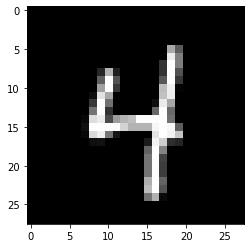

Prediction is = Number 4 (99.99%)


In [400]:
label = 19

predicted = list(model.predict(np.array([X_test_scaled[label]]))[0])
#print("prediction table:", predicted)
plt.imshow(X_test_scaled[label], cmap='gray')
plt.show()

predicted_label = labels[predicted.index(max(predicted))]
print("Prediction is =", predicted_label, f"({max(predicted)*100:.2f}%)")

# Class Scores

In [401]:
print(f"Prediction table for '{predicted_label}':")
print("\n",predicted)

Prediction table for 'Number 4':

 [1.1360338e-14, 6.761655e-05, 1.8850276e-06, 7.6032825e-07, 0.99987996, 1.0256237e-08, 6.7345123e-12, 4.859161e-06, 2.5060738e-06, 4.2330186e-05]


# Save

In [464]:
def create_csv_id():
    dir_path = os.path.join(os.path.dirname(os.getcwd()), 'models')
    file_path = os.path.join(dir_path, 'ids.csv')
    cur_id = 0
    # folder exists ?
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    # file exists ?
    if not os.path.exists(file_path):
        df = pd.DataFrame([0], columns=['id'])
        df.to_csv(file_path, index=False)
        return cur_id
    # csv -> dataframe
    df = pd.read_csv(file_path)
    cur_id = df["id"].iloc[-1] + 1
    
    with open(file_path, "a") as f:
        csv.writer(f).writerow([cur_id])
    return cur_id

create_csv_id()

0

In [402]:
joblib.dump(model, f'model_digits.joblib')

INFO:tensorflow:Assets written to: ram://c4ded182-a61b-4654-a60e-b8a3444d2afa/assets


['model_digits.joblib']